# Analyzing NYC Highschool SAT Data

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import re
import matplotlib as plt
%matplotlib inline

# create a list of all the csv files we want to read in
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# create dictionary where these imported files can later be called from
data = {}
# read each file in data_files and map to data
for f in data_files:
# load data from directory 'schools/'
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
# use proper encoding to read in txt files
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
# add both surveys into single df
survey = pd.concat([all_survey, d75_survey], axis=0)
#capitalize column name
survey["DBN"] = survey["dbn"]
# list of the column names in survey
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


# Add DBN columns

In [3]:
#change capitalization of column
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# function to turn a number into a string with format 04 for numbers less than 10
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
# convert values in class_size colname: csd -> string
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
# because DBN = csd + school code make a new column with these columns combined
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
# columns with string data that should be numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
# for each column
for c in cols:
# change the values from strings to numeric
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
# create a sat_score column in sat_results that is the sum of the three SAT section scores
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# function that uses a regex to find latitude from a coordinate location
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# function that uses a regex to find longitude from a coordinate location
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# add long and lat columns to the hs_directory so we can map them later on
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# make sure all of these values are numeric values
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
#create new instance of class_size df
class_size = data["class_size"]
#limit the rows to only those where grade is 9-12 (highschool grades)
class_size = class_size[class_size['GRADE '] == "09-12"]
#limit the rows to only those where the program type is gen ed (and not technical school)
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
#group the df by the DBN (unique schools) column and get the mean class size at the school
class_size = class_size.groupby("DBN").agg(np.mean)
#reset the index
class_size.reset_index(inplace=True)
#create a new column called class size with the mean class size we just found
data["class_size"] = class_size
#filter data so it is only from the school year 2011-2012
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
# filter so it is only the class of 2006
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
# filter so data only includes samples where the entire class is included
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]


# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
# convert the columns above into numeric values
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
# add all the test results, ap scores, and graduation data into a single df
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]
# add the class_size, demographics, survey, and hs directory dfs so that they must have corresponding DBN values
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
# for columns where there is no value in test results, fill them with the mean of the column
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
# gets first two characters from dbn column (the school district)
def get_first_two_chars(dbn):
    return dbn[0:2]
# create new column with this value
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
#get r valus from the new df
correlations = combined.corr()
# see what correlations exist between the columns and SAT score
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


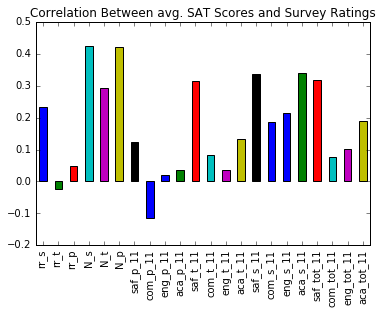

In [12]:
# plot results
combined.corr()["sat_score"][survey_fields].plot.bar(title='Correlation Between avg. SAT Scores and Survey Ratings')


<h4>Explanation of Graph</h4>
The column names consist of a combination of the following format:
- RR = response rate, N = number of respondents, Com = communication, Saf = safety and respect, Eng = engagement, Aca = academic expectations
- P = parent, T = teacher, S = student, tot = avg of these three scores

So, a column that with the name com_p contains the communication score as rated by the parents.

This graph shows the correlation between avg. SAT scores at the schools and these columns. 

First, only the N_s, N_t, N_p, saf_t, saf_s, aca_s, saf_tot columns have potentially statistically significant correlations (where the R value > 0.25).

I'm most suprised that the safety ratings of teachers and students have a correlation with SAT scores. It makes sense that people who feel safer at school would do better academically, however, I am suprised that this has a higher R value than the correlation between teacher's academic expectations and SAT scores. 

# Examining Safety vs. SAT Score

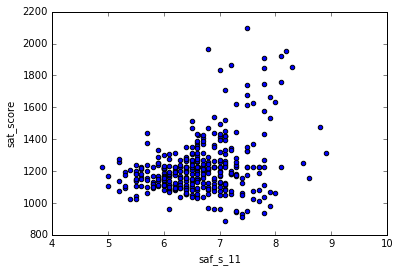

In [15]:
combined.plot.scatter("saf_s_11", "sat_score")

<h4>The Results</h4>
There appears to be a slight positiev correlation between student safety raings and SAT scores. However, there are a group of scores that appear to be outliers and these schools could be a major factor behind the positive correlation.

In [29]:
# create pivot table with the avg. student safety rating from each district in nyc
combined.pivot_table(values = 'saf_s_11',index = 'school_dist',aggfunc=np.mean)

,saf_s_11
school_dist,
01,6.768611
02,6.910660
03,6.716667
04,6.885714
05,6.314286
06,6.950000
07,6.800000
08,6.364697
09,6.655000


In [38]:
# see the mean of every score by school_dist value
districts = combined.groupby('school_dist').agg(np.mean)
districts

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,139.041709,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,97.597416,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,129.765099,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,100.118588,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240


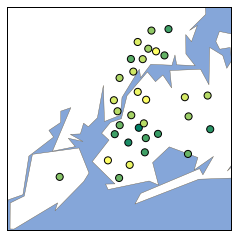

In [45]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

Schools in Manhattan and in parts of Queens have a higher avg. safety rating than schools in Brooklyn.

# Correlations Between Race and SAT Score

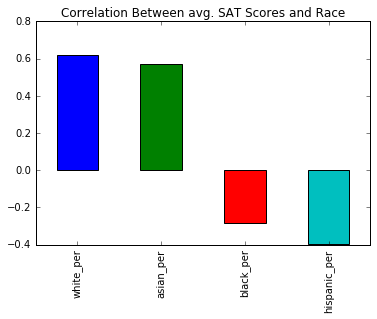

In [47]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()["sat_score"][race_cols].plot.bar(title='Correlation Between avg. SAT Scores and Race')


<h4>Findings</h4>
There are strong positive correlations between white and asian students and having a high SAT score while there is a strong negative correlation between black and hispanic students and SAT score.

According to this preliminary analysis, race plays a big role in a students SAT store.

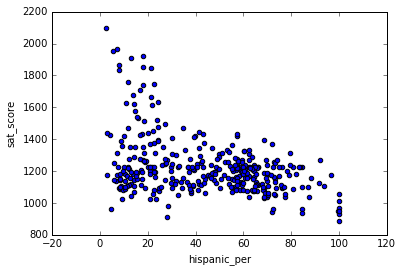

In [50]:
combined.plot.scatter('hispanic_per','sat_score')

This graph confirms a negative correlation between the percentage of hispanic students at a school and the avg. SAT score of the school.

In [55]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [59]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])


37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


# SAT Score by Gender

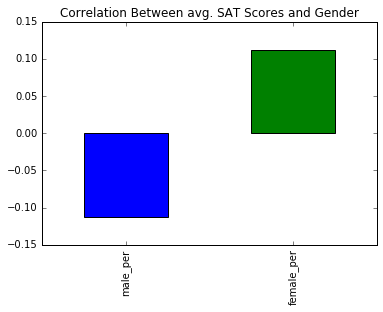

In [60]:
gender_cols = ['male_per','female_per']
combined.corr()["sat_score"][gender_cols].plot.bar(title='Correlation Between avg. SAT Scores and Gender')


There is a weak negative correlation between male percentage and sat scores and a weak positive correlation between female percentage and sat scores.

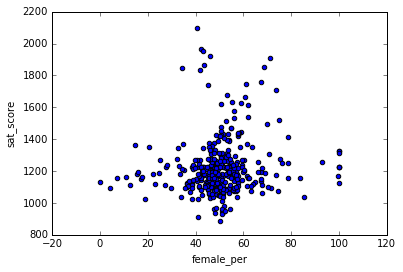

In [62]:
combined.plot.scatter('female_per','sat_score')

In [63]:
combined[(combined['female_per']>60)&(combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# AP students vs. SAT Score

In [66]:
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']

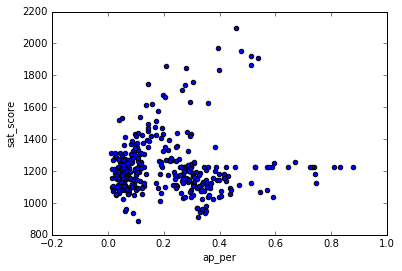

In [67]:
combined.plot.scatter('ap_per','sat_score')